<a href="https://colab.research.google.com/github/VenissaCarolQuadros/COMP551/blob/report/COMP551_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Imports

In [268]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [269]:
def read_data(url, dest):
  response = requests.get(url)
  with open(dest, 'wb') as file:
      file.write(response.content)
  return

In [270]:
dest1= 'LinearRegression.xlsx'
read_data("https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/ENB2012_data.xlsx", dest1)
df1= pd.read_excel(dest1)
df1.columns = ['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

dest2= 'LogisticRegression.csv'
read_data('https://raw.githubusercontent.com/VenissaCarolQuadros/COMP551/main/data/Qualitative_Bankruptcy/Qualitative_Bankruptcy.data.txt', dest2)
df2= pd.read_csv(dest2, header=None)


In [271]:
print("Verifying shape of df1:", df1.shape, "\nVerifying shape of df2:", df2.shape) ##Verifying dataset size
print( "Checking for nulls in df1:", df1[df1.eq('?').any(1)])
print("Checking for nulls in df1:", df2[ df2.eq('?').any(1)]) #Checking for nulls
##No nulls found. Dataset size seems right

Verifying shape of df1: (768, 10) 
Verifying shape of df2: (250, 7)
Checking for nulls in df1: Empty DataFrame
Columns: [relative_compactness, surface_area, wall_area, roof_area, overall_height, orientation, glazing_area, glazing_area_distribution, heating_load, cooling_load]
Index: []
Checking for nulls in df1: Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6]
Index: []


##Gradient Descent

In [272]:

class GradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
        self.cost_history=[]
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad, cost = gradient_fn(x, y, w)               # compute the gradient with present weight
            self.cost_history.append(cost)
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

In [273]:
class StochasticGradientDescent:
    
    def __init__(self, learning_rate=.0001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
        #self.cost_history=[]
          
    def run(self, gradient_fn, x, y, w, batch_size):
        learning_rate=self.learning_rate
        grad = np.inf
        t = 1
        instance=0
        while t < self.max_iters:
            mini_batches =self.create_mini_batches(x, y, batch_size)
            for mini_batch in mini_batches:
                x_mini, y_mini= mini_batch
                grad = gradient_fn(x_mini, y_mini, w)
                #self.cost_history.append(cost)
                w = w - learning_rate * grad         # weight update step
                learning_rate=self.learning_rate/t
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

    def create_mini_batches(self, x, y, batch_size):
      mini_batches = []
      if len(y.shape)==1:
        y=y[:, np.newaxis]
      data = np.hstack((x, y))
      #print(x.shape, y.shape)
      np.random.shuffle(data)
      n_minibatches = data.shape[0] // batch_size
      i = 0
  
      for i in range(n_minibatches + 1):
          mini_batch = data[i * batch_size:(i + 1)*batch_size, :]
          X_mini = mini_batch[:, :-(y.shape[1])]
          Y_mini = mini_batch[:, (X_mini.shape[1]):]
          #print(X_mini.shape, Y_mini.shape)
          mini_batches.append((X_mini, Y_mini))
      if data.shape[0] % batch_size != 0:
          mini_batch = data[i * batch_size:data.shape[0]]
          X_mini = mini_batch[:, :-(y.shape[1])]
          Y_mini = mini_batch[:, (X_mini.shape[1]):]
          #print(X_mini.shape, Y_mini.shape)
          mini_batches.append((X_mini, Y_mini))
      return mini_batches

##Linear Regression

In [274]:
class LinearRegression:
  def __init__(self):
    ()
  
  def editData(self):
    self.X= np.c_[np.ones((self.X).shape[0]), (self.X)] 
    return
  
  def fitClosedForm(self, X, Y):
    self.X=X
    self.Y=Y
    self.editData()
    self.w= np.linalg.inv((self.X).T @ (self.X))@ (self.X).T@ (self.Y)
    #print(self.w)
    return self.w

  def fitGD(self, X, Y, optimizer):#, optimizer2):
      self.X=X
      self.Y=Y
      self.editData()
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))
      def gradient(x, y, w):                          # define the gradient function
          yh =  x @ w 
          N, D = x.shape
          grad = (x.T@ (yh - y))/N
          return grad, .5*np.mean((yh - y)**2)
      self.w = optimizer.run(gradient, self.X, self.Y, self.w)      
      return self.w

  def fitSGD(self, X, Y, optimizer, batch_size):
      self.X=X
      self.Y=Y
      self.editData()
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))
      def gradient(x, y, w):                          # define the gradient function
          yh =  x @ w
          grad = (x.T@ (yh - y))/(batch_size)
          return grad#, .5*np.mean((yh - y)**2)
      self.w = optimizer.run(gradient, self.X, self.Y, self.w, batch_size)
      return self.w

  def predict(self, Xt):
    Xt= np.c_[np.ones((Xt).shape[0]), (Xt)] 
    return Xt @ self.w
  
  

##Logistic Regression

In [275]:
logistic = lambda z: 1./ (1 + np.exp(-z))
class LogisticRegression:
  
  def editData(self):
    self.X= np.c_[np.ones((self.X).shape[0]), (self.X)] 
    return

  def fitGD(self, X, Y, optimizer):
      self.X= X
      self.Y= Y#np.squeeze(Y)
      self.editData()
      def gradient(x, y, w):
          N,D = x.shape
          yh = logistic(x @ w)   # predictions  size N
          grad = (x.T@ (yh - y))/N#np.dot(yh-y, x)/N
          return grad, self.cost_fn(x,y,w)
      #w0 = np.zeros(self.X.shape[1])                            # initialize the weights
      #print(self.X.shape, w0.shape) 
      self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))  
      self.w = optimizer.run(gradient, self.X, self.Y, self.w)      # run the optimizer to get the optimal weights
      return self.w

  def fitSGD(self, X, Y, optimizer, batch_size):
    self.X= X
    self.Y= Y#np.squeeze(Y)
    self.editData()
    def gradient(x, y, w):
        yh = logistic(x @ w)   # predictions  size N
        grad = (x.T@ (yh - y))/(batch_size)
        return grad#, self.cost_fn(x,y,w)
    self.w=np.zeros((self.X.shape[1], self.Y.shape[1]))                            # initialize the weights
    self.w = optimizer.run(gradient, self.X, self.Y, self.w, batch_size)      # run the optimizer to get the optimal weights
    return self.w

  def cost_fn(self, x, y, w):
    N, D = x.shape                                                       
    z = np.dot(x, w)
    J =np.mean(np.squeeze(y) * np.squeeze(np.log1p(np.exp(-z))) + (1-np.squeeze(y)) * np.squeeze(np.log1p(np.exp(z)))) #log1p calculates log(1+x) to remove floating point inaccuracies 
    return J

  def predict(self, Xt):
    Xt= np.c_[np.ones((Xt).shape[0]), (Xt)] 
    return logistic(Xt @ self.w)
 

##Cross Validate

In [276]:
def cross_validate(n, n_folds=5):
    #get the number of data samples in each split
    n_val = n // n_folds
    inds = np.random.permutation(n)
    inds = []
    for f in range(n_folds):
        tr_inds = []
        #get the validation indexes
        val_inds = list(range(f * n_val, (f+1)*n_val))
        #get the train indexes
        if f > 0:
            tr_inds = list(range(f*n_val))
        if f < n_folds - 1:
            tr_inds = tr_inds + list(range((f+1)*n_val, n))
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield tr_inds, val_inds

## Confusion Matrix

In [277]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix

## Data Analysis

<Figure size 360x360 with 0 Axes>

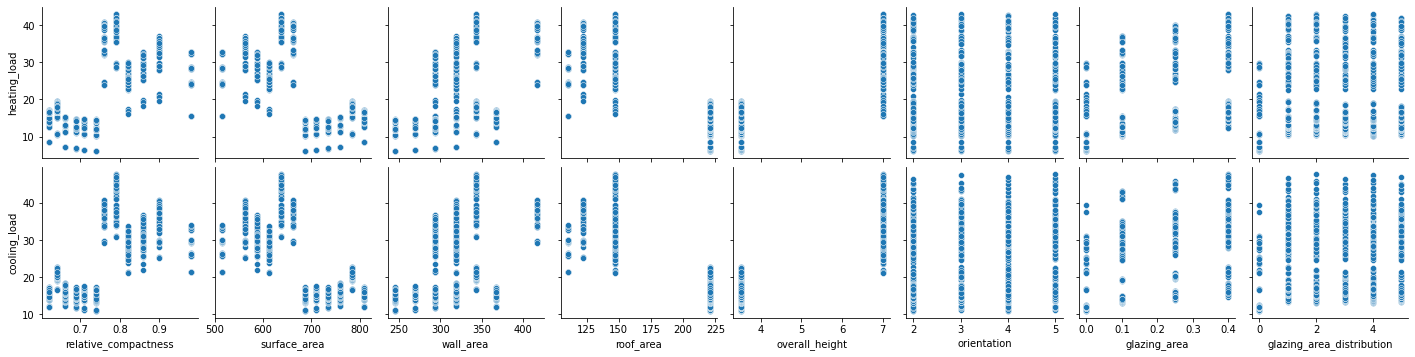

Statistical Description:        relative_compactness  surface_area   wall_area   roof_area  \
count            768.000000    768.000000  768.000000  768.000000   
mean               0.764167    671.708333  318.500000  176.604167   
std                0.105777     88.086116   43.626481   45.165950   
min                0.620000    514.500000  245.000000  110.250000   
25%                0.682500    606.375000  294.000000  140.875000   
50%                0.750000    673.750000  318.500000  183.750000   
75%                0.830000    741.125000  343.000000  220.500000   
max                0.980000    808.500000  416.500000  220.500000   

       overall_height  orientation  glazing_area  glazing_area_distribution  \
count       768.00000   768.000000    768.000000                  768.00000   
mean          5.25000     3.500000      0.234375                    2.81250   
std           1.75114     1.118763      0.133221                    1.55096   
min           3.50000     2.000000   

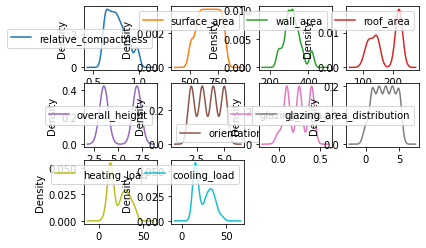

In [278]:
plt.figure(figsize=(5,5))
sns.pairplot(data=df1, y_vars=['heating_load', 'cooling_load'], x_vars=['relative_compactness', 'surface_area', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution'])
plt.show()

df1.plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False)

print("Statistical Description:", df1.describe())
print("Correlation:", df1.corr(method='pearson'))

In [279]:
## Encoding for categorical data
data2= df2.copy(deep=True)
data2[6].replace(['NB', 'B'], [0, 1], inplace=True)
for i in range(6):
  data2[i].replace(['N', 'A', 'P'], [-1, 0, 1], inplace=True)
data2.head()

,0,1,2,3,4,5,6
0,1,1,0,0,0,1,0
1,-1,-1,0,0,0,-1,0
2,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0
4,-1,-1,1,1,1,-1,0


Statistical Description:                 0          1           2           3           4          5  \
count  250.000000  250.00000  250.000000  250.000000  250.000000  250.00000   
mean    -0.036000   -0.22800   -0.248000   -0.060000   -0.048000   -0.14000   
std      0.823051    0.82141    0.803166    0.831363    0.881364    0.86915   
min     -1.000000   -1.00000   -1.000000   -1.000000   -1.000000   -1.00000   
25%     -1.000000   -1.00000   -1.000000   -1.000000   -1.000000   -1.00000   
50%      0.000000    0.00000    0.000000    0.000000    0.000000    0.00000   
75%      1.000000    0.00000    0.000000    1.000000    1.000000    1.00000   
max      1.000000    1.00000    1.000000    1.000000    1.000000    1.00000   

                6  
count  250.000000  
mean     0.428000  
std      0.495781  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000  
Correlation:           0         1         2         3         4         5         

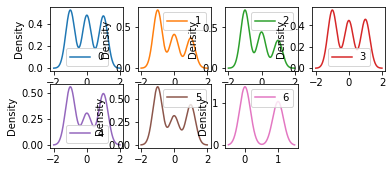

In [280]:
data2.plot(kind='density', subplots=True, layout=(3,4), sharex=False, sharey=False)

print("Statistical Description:", data2.describe())
print("Correlation:", data2.corr())

##Experiments

In [281]:
#Train test split

data1= df1.copy(deep=True)
data1.drop(columns=['orientation','glazing_area_distribution'], inplace=True)

train=data1.sample(frac=0.8, random_state=200)
test=data1.drop(train.index)

X_train= train.iloc[:, :6].to_numpy(copy=True) 
X_train= (X_train-X_train.min(axis=0))/ (X_train.max(axis=0)- X_train.min(axis=0))
Y_train= train.iloc[:, 6:].to_numpy(copy=True)



X_test= test.iloc[:, :6].to_numpy(copy=True)
X_test= (X_test- X_test.min(axis=0))/ (X_test.max(axis=0)- X_test.min(axis=0))
Y_test= test.iloc[:, 6:].to_numpy(copy=True)



In [282]:
model1= LinearRegression()
weights= model1.fitClosedForm(X_train, Y_train)
Ypredict=model1.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train)
loss1=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", weights)

MSE Cost for train set: [12.87548908 15.38340012]
MSE Cost for test set: [13.18640355 16.71347891]
Weights: [[  7.22052678   8.9408155 ]
 [ -0.61589625   0.57439023]
 [-17.49285244 -20.10818644]
 [ 20.72171977  21.42764881]
 [ 12.56657302  17.02995484]
 [ 14.77476351  15.2801185 ]
 [  8.26975338   5.99151998]]


In [315]:
## Prepping data for comparison of linear regression without feature selection and normalization
data1_unmod= df1.copy(deep=True)

train_u=data1_unmod.sample(frac=0.8, random_state=200)
test_u=data1_unmod.drop(train.index)

X_train_u= train_u.iloc[:, :8].to_numpy(copy=True) 
Y_train_u= train_u.iloc[:, 8:].to_numpy(copy=True)

X_test_u= test_u.iloc[:, :8].to_numpy(copy=True)
Y_test_u= test_u.iloc[:, 8:].to_numpy(copy=True)

In [316]:
##Analytical solution comparing performance without feature selection and normalization
model1= LinearRegression()
weights= model1.fitClosedForm(X_train_u, Y_train_u)
Ypredict=model1.predict(X_test_u)
loss=0.5*np.mean((Y_test_u-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train_u)
loss1=0.5*np.mean((Y_train_u-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", weights)

MSE Cost for train set: [ 942.55152154 1157.65805386]
MSE Cost for test set: [ 892.94085188 1103.93767733]
Weights: [[-3.28957372e+03 -3.62825555e+03]
 [ 2.12928774e+03  2.35181051e+03]
 [ 2.27906072e+00  2.52438420e+00]
 [ 2.53122443e-01  2.57875279e-01]
 [ 4.39821434e-01  4.89170725e-01]
 [ 4.23603328e+00  4.37473150e+00]
 [-2.18248874e-02  1.26656032e-01]
 [ 2.01477994e+01  1.48691004e+01]
 [ 2.13466844e-01  3.48788842e-02]]


In [321]:
##Analytical solution comparing performance with normalization but without feature selection
data1_unmod= df1.copy(deep=True)

train_u=data1_unmod.sample(frac=0.8, random_state=200)
test_u=data1_unmod.drop(train.index)

X_train_u= train_u.iloc[:, :8].to_numpy(copy=True) 
X_train_u= (X_train_u-X_train_u.min(axis=0))/ (X_train_u.max(axis=0)- X_train_u.min(axis=0))
Y_train_u= train_u.iloc[:, 8:].to_numpy(copy=True)



X_test_u= test_u.iloc[:, :8].to_numpy(copy=True)
X_test_u=(X_test_u-X_test_u.min(axis=0))/ (X_test_u.max(axis=0)- X_test_u.min(axis=0))
Y_test_u= test_u.iloc[:, 8:].to_numpy(copy=True)

In [286]:
##Analytical solution comparing performance without feature selection
model1= LinearRegression()
weights= model1.fitClosedForm(X_train_u, Y_train_u)
Ypredict=model1.predict(X_test_u)
loss=0.5*np.mean((Y_test_u-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train_u)
loss1=0.5*np.mean((Y_train_u-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", weights)

MSE Cost for train set: [ 9.8816175  12.30000965]
MSE Cost for test set: [ 9.14404174 12.05005971]
Weights: [[ 7.08983465e+01  8.16460279e+01]
 [-7.01781714e+01 -7.84071660e+01]
 [-9.88629443e+01 -1.10882641e+02]
 [ 2.14936862e+01  2.16784021e+01]
 [ 2.15643147e+01  2.62986256e+01]
 [ 1.48261165e+01  1.53115603e+01]
 [-6.54746622e-02  3.79968096e-01]
 [ 8.05911977e+00  5.94764018e+00]
 [ 1.06733422e+00  1.74394421e-01]]


In [287]:
train1=data2.sample(frac=0.8, random_state=200)
test1=data2.drop(train1.index)

X_train1= train1.iloc[:, :6].to_numpy(copy=True) 
Y_train1= train1.iloc[:, 6:].to_numpy(copy=True)

X_test1= test1.iloc[:, :6].to_numpy(copy=True) 
Y_test1= test1.iloc[:, 6:].to_numpy(copy=True)

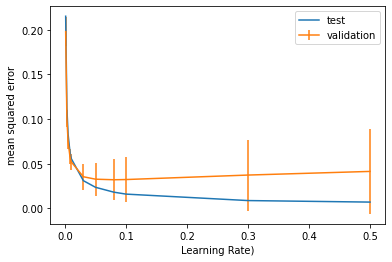

In [288]:
num_folds = 5
model = LogisticRegression()
learning_rates=[0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.3, 0.5]
err_test, err_valid = np.zeros(len(learning_rates)), np.zeros((len(learning_rates), num_folds))
for i, K in enumerate(learning_rates):
    for f, (tr, val) in enumerate(cross_validate(X_train1.shape[0], num_folds)):
        optimizer = GradientDescent(learning_rate=K, max_iters=5000, record_history=False)
        W = model.fitGD(X_train1[tr, :], Y_train1[tr, :], optimizer)
        err_valid[i, f] = model.cost_fn(np.c_[np.ones((X_train1[val]).shape[0]), (X_train1[val])] , np.squeeze(Y_train1[val]), W)
    params = model.fitGD(X_train1[tr, :], Y_train1[tr, :], optimizer)
    err_test[i]= model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W)
    
plt.plot(learning_rates, err_test,  label='test')
plt.errorbar(learning_rates, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Learning Rate)')
plt.ylabel('mean squared error')
plt.show()

In [289]:
optimizer = GradientDescent(learning_rate=.03, max_iters=5000, record_history=False)#GradientDescent(learning_rate=.0003, max_iters=5000, record_history=False)
model= LogisticRegression()
W=model.fitGD(X_train1, Y_train1, optimizer)
Ypredict=model.predict(X_test1)
Ypredict1=model.predict(X_train1)
print("Weights:", W)
print("MSE Cost for train set:", model.cost_fn(np.c_[np.ones((X_train1).shape[0]), (X_train1)] , np.squeeze(Y_train1), W))
print("MSE Cost for test set:", model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W))

Weights: [[-1.92565578]
 [-0.72190659]
 [-0.20429607]
 [-2.09209586]
 [-2.06759473]
 [-3.47068638]
 [-0.27956148]]
MSE Cost for train set: 0.023506164503018415
MSE Cost for test set: 0.03455612621372145


In [290]:
decision_boundary=0.5
cmat = confusion_matrix(Y_train1, (Ypredict1>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat)
print(f'Accuracy on train data: {np.sum(np.diag(cmat))/np.sum(cmat)}')
print(f'Precision on train data: {cmat[0,0]/(cmat[0,0]+cmat[0,1])}')
print(f'Recall on train data: {cmat[0,0]/(cmat[0,0]+cmat[1,0])}')
cmat1 = confusion_matrix(Y_test1, (Ypredict>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat1)
print(f'Accuracy on test data: {np.sum(np.diag(cmat1))/np.sum(cmat1)}')
print(f'Precision on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[0,1])}')
print(f'Recall on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[1,0])}')

Confusion matrix on train data:
 [[114.   0.]
 [  1.  85.]]
Accuracy on train data: 0.995
Precision on train data: 1.0
Recall on train data: 0.991304347826087
Confusion matrix on train data:
 [[29.  0.]
 [ 0. 21.]]
Accuracy on test data: 1.0
Precision on train data: 1.0
Recall on train data: 1.0


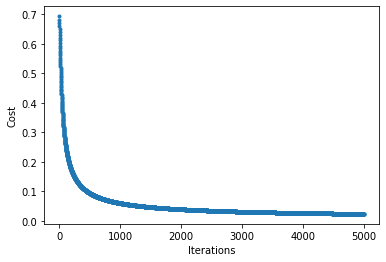

In [291]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(optimizer.cost_history)), optimizer.cost_history, '.')

plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

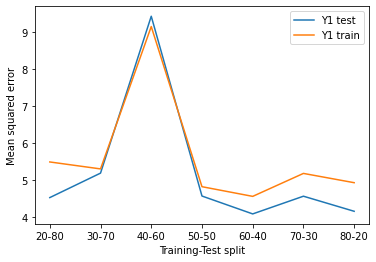

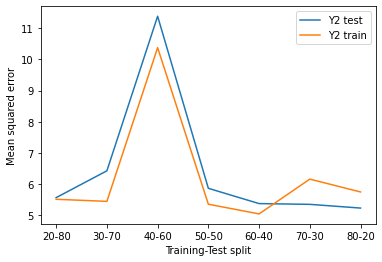

In [292]:
splits=np.arange(start=0.2, stop=0.8, step=0.1)
err_test, err_train = np.zeros((len(splits), 2)), np.zeros((len(splits), 2))
model1= LinearRegression()
for i, split in enumerate(splits):
    train=data1.sample(frac=split, random_state=200)
    test=data1.drop(train.index)
    X_train= train.iloc[:, :6].to_numpy(copy=True) 
    X_train= X_train/ X_train.max(axis=0)
    Y_train= train.iloc[:, 6:].to_numpy(copy=True)
    X_test= test.iloc[:, :6].to_numpy(copy=True)
    X_test= X_test/ X_test.max(axis=0)
    Y_test= test.iloc[:, 6:].to_numpy(copy=True)

    weights= model1.fitClosedForm(X_train, Y_train)
    Ypredict=model1.predict(X_test)
    err_test[i, :]=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
    Ypredict1=model1.predict(X_train)
    err_train[i, :]=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)

plt.plot(splits, err_test[:,0],  label='Y1 test')
plt.plot(splits, err_train[:,0], label='Y1 train')

#plt.plot(splits, err_test[:,1],  label='Y2 test')
#plt.plot(splits, err_train[:,1], label='Y2 train')
plt.xticks(ticks=splits, labels=['20-80', '30-70', '40-60', '50-50', '60-40', '70-30', '80-20'])
plt.legend()
plt.xlabel('Training-Test split')
plt.ylabel('Mean squared error')
plt.show()

plt.plot(splits, err_test[:,1],  label='Y2 test')
plt.plot(splits, err_train[:,1], label='Y2 train')
plt.xticks(ticks=splits, labels=['20-80', '30-70', '40-60', '50-50', '60-40', '70-30', '80-20'])
plt.legend()
plt.xlabel('Training-Test split')
plt.ylabel('Mean squared error')
plt.show()

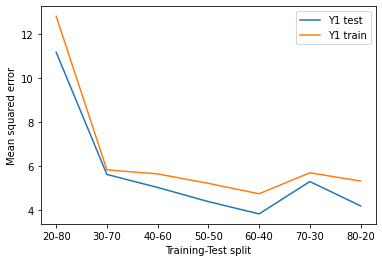

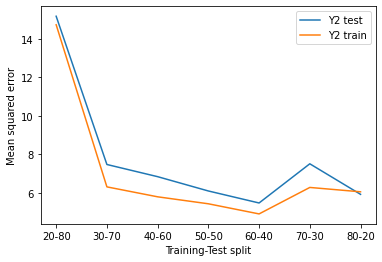

In [293]:
splits=np.arange(start=0.2, stop=0.8, step=0.1)
err_test, err_train = np.zeros((len(splits), 2)), np.zeros((len(splits), 2))
model1= LinearRegression()
for i, split in enumerate(splits):
    train=data1.sample(frac=split, random_state=0)
    test=data1.drop(train.index)
    X_train= train.iloc[:, :6].to_numpy(copy=True) 
    X_train= X_train/ X_train.max(axis=0)
    Y_train= train.iloc[:, 6:].to_numpy(copy=True)
    X_test= test.iloc[:, :6].to_numpy(copy=True)
    X_test= X_test/ X_test.max(axis=0)
    Y_test= test.iloc[:, 6:].to_numpy(copy=True)

    weights= model1.fitClosedForm(X_train, Y_train)
    Ypredict=model1.predict(X_test)
    err_test[i, :]=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
    Ypredict1=model1.predict(X_train)
    err_train[i, :]=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)

plt.plot(splits, err_test[:,0],  label='Y1 test')
plt.plot(splits, err_train[:,0], label='Y1 train')

#plt.plot(splits, err_test[:,1],  label='Y2 test')
#plt.plot(splits, err_train[:,1], label='Y2 train')
plt.xticks(ticks=splits, labels=['20-80', '30-70', '40-60', '50-50', '60-40', '70-30', '80-20'])
plt.legend()
plt.xlabel('Training-Test split')
plt.ylabel('Mean squared error')
plt.show()

plt.plot(splits, err_test[:,1],  label='Y2 test')
plt.plot(splits, err_train[:,1], label='Y2 train')
plt.xticks(ticks=splits, labels=['20-80', '30-70', '40-60', '50-50', '60-40', '70-30', '80-20'])
plt.legend()
plt.xlabel('Training-Test split')
plt.ylabel('Mean squared error')
plt.show()

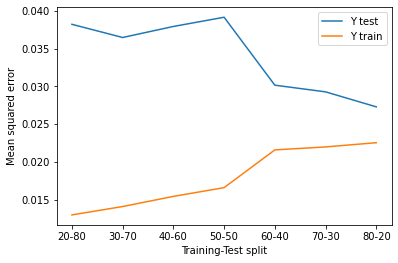

In [294]:
splits=np.arange(start=0.2, stop=0.8, step=0.1)
err_test, err_train = np.zeros(len(splits)), np.zeros(len(splits))
model= LogisticRegression()
for i, split in enumerate(splits):
    train1=data2.sample(frac=split, random_state=0)
    test1=data2.drop(train1.index)

    X_train1= train1.iloc[:, :6].to_numpy(copy=True) 
    Y_train1= train1.iloc[:, 6:].to_numpy(copy=True)

    X_test1= test1.iloc[:, :6].to_numpy(copy=True) 
    Y_test1= test1.iloc[:, 6:].to_numpy(copy=True)

    optimizer = GradientDescent(learning_rate=.03, max_iters=5000, record_history=False)
    W=model.fitGD(X_train1, Y_train1, optimizer)
    err_train[i]= model.cost_fn(np.c_[np.ones((X_train1).shape[0]), (X_train1)] , np.squeeze(Y_train1), W)
    err_test[i]= model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W)



plt.plot(splits, err_test,  label='Y test')
plt.plot(splits, err_train, label='Y train')

plt.xticks(ticks=splits, labels=['20-80', '30-70', '40-60', '50-50', '60-40', '70-30', '80-20'])
plt.legend()
plt.xlabel('Training-Test split')
plt.ylabel('Mean squared error')
plt.show()

MSE for batch size 8 on test set: [15666533.42628917 14859860.40290446]
MSE for batch size 16 on test set: [492.08321012 571.67954006]
MSE for batch size 32 on test set: [4.47517344 6.09142702]
MSE for batch size 64 on test set: [5.28188686 6.76640274]
MSE for batch size 128 on test set: [6.18225264 7.50217275]
MSE for batch size 256 on test set: [ 9.29814438 10.20509748]
MSE for batch size 512 on test set: [17.08786819 17.00712798]
MSE for batch size 614 on test set: [21.56622496 20.93507709]


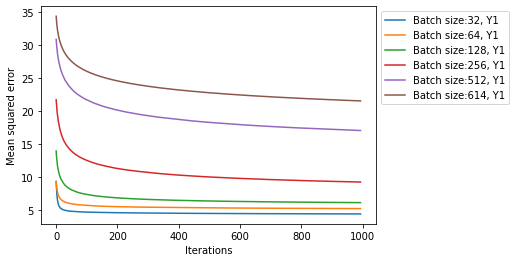

In [295]:
model= LinearRegression()
batch_sizes=[8, 16, 32, 64, 128, 256, 512, len(X_train)]
weight_history=[]
for batch_size in batch_sizes:
    #for i, lr in enumerate(learning_rates):
    optimizer = StochasticGradientDescent(learning_rate=0.5, max_iters=1000, record_history=True) 
    W=model.fitSGD(X_train, Y_train, optimizer, batch_size)
    Ypredict=model.predict(X_test)
    print("MSE for batch size", batch_size, "on test set:", 0.5*np.mean((Y_test-Ypredict)**2, axis=0))
    costs1=[]
    costs2=[]
    for w in optimizer.w_history:
      yh =  np.c_[np.ones((X_test).shape[0]), (X_test)]  @ w[:,0]
      costs1.append(0.5*np.mean((Y_test[:,0]-yh)**2, axis=0))
      yh =  np.c_[np.ones((X_test).shape[0]), (X_test)]  @ w[:,1]
      costs2.append(0.5*np.mean((Y_test[:,1]-yh)**2, axis=0))
    if (costs1[5]<5000 and costs2[5]<5000):
      plt.plot(np.arange(len(costs1[5:])), costs1[5:], label='Batch size:'+str(batch_size)+", Y1")
      #plt.plot(np.arange(len(costs2[5:])), costs2[5:], label='Batch size:'+str(batch_size)+", Y2")

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Mean squared error")
plt.xlabel("Iterations")

plt.show()

    


MSE for batch size 8 with learning rate 0.05 on test set: [5.59460083 7.00573657]
MSE for batch size 8 with learning rate 0.1 on test set: [4.86220522 6.44061868]
MSE for batch size 8 with learning rate 0.5 on test set: [54253368.71641778 81275054.40854883]
MSE for batch size 16 with learning rate 0.05 on test set: [7.62699889 8.76800362]
MSE for batch size 16 with learning rate 0.1 on test set: [5.60578942 7.01644967]
MSE for batch size 16 with learning rate 0.5 on test set: [ 68.00668655 102.30263032]
MSE for batch size 32 with learning rate 0.05 on test set: [13.92193555 14.24970743]
MSE for batch size 32 with learning rate 0.1 on test set: [7.57911793 8.71486773]
MSE for batch size 32 with learning rate 0.5 on test set: [5.566244   7.16276545]


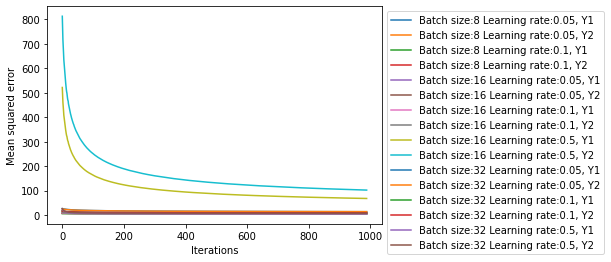

In [296]:
model= LinearRegression()
learning_rates=[0.05, 0.1, 0.5]
batch_sizes=[8, 16, 32]
weight_history=[]
for batch_size in batch_sizes:
    for i, lr in enumerate(learning_rates):
      optimizer = StochasticGradientDescent(learning_rate=lr, max_iters=1000, record_history=True) 
      W=model.fitSGD(X_train, Y_train, optimizer, batch_size)
      Ypredict=model.predict(X_test)
      print("MSE for batch size", batch_size, "with learning rate", lr, "on test set:", 0.5*np.mean((Y_test-Ypredict)**2, axis=0))
      costs1=[]
      costs2=[]
      for w in optimizer.w_history: #weights are take at each epoch and not at each step
        yh =  np.c_[np.ones((X_test).shape[0]), (X_test)]  @ w[:,0]
        costs1.append(0.5*np.mean((Y_test[:,0]-yh)**2, axis=0))
        yh =  np.c_[np.ones((X_test).shape[0]), (X_test)]  @ w[:,1]
        costs2.append(0.5*np.mean((Y_test[:,1]-yh)**2, axis=0))
      if (costs1[10]<5000 and costs2[10]<5000):
        plt.plot(np.arange(len(costs1[10:])), costs1[10:], label='Batch size:'+str(batch_size)+" Learning rate:"+str(lr)+", Y1")
        plt.plot(np.arange(len(costs2[10:])), costs2[10:], label='Batch size:'+str(batch_size)+" Learning rate:"+str(lr)+", Y2")

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Mean squared error")
plt.xlabel("Iterations")

plt.show()


In [297]:
optimizer = StochasticGradientDescent(learning_rate=0.5, max_iters=5000, record_history=False) 
model1= LinearRegression()
W= model1.fitSGD(X_train, Y_train, optimizer, 32)
Ypredict=model1.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train)
loss1=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", W)

MSE Cost for train set: [4.83300816 5.54290812]
MSE Cost for test set: [4.14399107 5.81602086]
Weights: [[ -0.57054221   0.81375498]
 [ -7.34129268  -5.62893681]
 [  1.58595906   1.98454398]
 [ 16.4248553   14.40748017]
 [-12.60477173  -9.96873398]
 [ 26.52239443  26.52000449]
 [  8.33573709   6.06092632]]


In [325]:
##With feature selection
optimizer = GradientDescent(learning_rate=0.3, max_iters=1e4, record_history=False) 
model1= LinearRegression()
W= model1.fitGD(X_train, Y_train, optimizer)
Ypredict=model1.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train)
loss1=0.5*np.mean((Y_train-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", W)

MSE Cost for train set: [4.57572938 5.16688774]
MSE Cost for test set: [3.80684327 5.46124738]
Weights: [[  1.48424389   2.91984466]
 [-19.41428294 -19.39899602]
 [  1.70539316   1.91074328]
 [ 11.23278428   6.88717811]
 [ -7.48218659  -3.00152776]
 [ 35.96467016  38.28418557]
 [  8.40008645   6.11850345]]


In [326]:
#Without feature selection
optimizer = GradientDescent(learning_rate=0.3, max_iters=1e4, record_history=False) 
model1= LinearRegression()
W= model1.fitGD(X_train_u, Y_train_u, optimizer)
Ypredict=model1.predict(X_test_u)
loss=0.5*np.mean((Y_test_u-Ypredict)**2, axis=0)
Ypredict1=model1.predict(X_train_u)
loss1=0.5*np.mean((Y_train_u-Ypredict1)**2, axis=0)
print("MSE Cost for train set:", loss1)
print("MSE Cost for test set:", loss)
print("Weights:", W)

MSE Cost for train set: [4.43865622 5.19317253]
MSE Cost for test set: [3.60773137 5.31792304]
Weights: [[ 16.6199489   20.03575743]
 [-11.868139   -12.26234311]
 [ -4.06479444  -4.33333954]
 [  4.34461306   2.57646523]
 [ -5.10554743  -3.32931292]
 [ 17.0829383   17.84977448]
 [ -0.048536     0.39901876]
 [  8.02705755   5.91158026]
 [  1.10305547   0.21456959]]


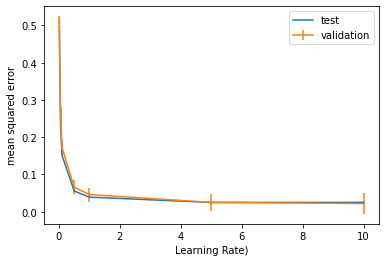

In [300]:
num_folds = 5
model = LogisticRegression()
learning_rates=[0.01, 0.05, 0.1, 0.5, 1, 5, 10]
err_test, err_valid = np.zeros(len(learning_rates)), np.zeros((len(learning_rates), num_folds))
for i, K in enumerate(learning_rates):
    for f, (tr, val) in enumerate(cross_validate(X_train1.shape[0], num_folds)):
        optimizer = StochasticGradientDescent(learning_rate=K, max_iters=5000, record_history=False)
        W = model.fitSGD(X_train1[tr, :], Y_train1[tr, :], optimizer, 24)
        err_valid[i, f] = model.cost_fn(np.c_[np.ones((X_train1[val]).shape[0]), (X_train1[val])] , np.squeeze(Y_train1[val]), W)
    params = model.fitSGD(X_train1[tr, :], Y_train1[tr, :], optimizer, 24)
    err_test[i]= model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W)
    
plt.plot(learning_rates, err_test,  label='test')
plt.errorbar(learning_rates, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Learning Rate)')
plt.ylabel('mean squared error')
plt.show()

In [301]:
optimizer = StochasticGradientDescent(learning_rate=5, max_iters=5000, record_history=False)#GradientDescent(learning_rate=.0003, max_iters=5000, record_history=False)
model= LogisticRegression()
W=model.fitSGD(X_train1, Y_train1, optimizer, 24)
Ypredict=model.predict(X_test1)
Ypredict1=model.predict(X_train1)
print("Weights:", W)
print("MSE Cost for train set:", model.cost_fn(np.c_[np.ones((X_train1).shape[0]), (X_train1)] , np.squeeze(Y_train1), W))
print("MSE Cost for test set:", model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), W))

Weights: [[-2.77592013]
 [-0.44033876]
 [-0.62885754]
 [-2.21186651]
 [-2.55108076]
 [-5.14647246]
 [ 0.22033602]]
MSE Cost for train set: 0.0112919036018437
MSE Cost for test set: 0.022725182582572116


In [302]:
decision_boundary=0.5
cmat = confusion_matrix(Y_train1, (Ypredict1>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat)
print(f'Accuracy on train data: {np.sum(np.diag(cmat))/np.sum(cmat)}')
print(f'Precision on train data: {cmat[0,0]/(cmat[0,0]+cmat[0,1])}')
print(f'Recall on train data: {cmat[0,0]/(cmat[0,0]+cmat[1,0])}')
cmat1 = confusion_matrix(Y_test1, (Ypredict>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat1)
print(f'Accuracy on test data: {np.sum(np.diag(cmat1))/np.sum(cmat1)}')
print(f'Precision on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[0,1])}')
print(f'Recall on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[1,0])}')

Confusion matrix on train data:
 [[118.   0.]
 [  0.  82.]]
Accuracy on train data: 1.0
Precision on train data: 1.0
Recall on train data: 1.0
Confusion matrix on train data:
 [[24.  1.]
 [ 0. 25.]]
Accuracy on test data: 0.98
Precision on train data: 0.96
Recall on train data: 1.0


In [303]:
##Varying decision boundary
decision_boundary=0.55
cmat = confusion_matrix(Y_train1, (Ypredict1>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat)
print(f'Accuracy on train data: {np.sum(np.diag(cmat))/np.sum(cmat)}')
print(f'Precision on train data: {cmat[0,0]/(cmat[0,0]+cmat[0,1])}')
print(f'Recall on train data: {cmat[0,0]/(cmat[0,0]+cmat[1,0])}')
cmat1 = confusion_matrix(Y_test1, (Ypredict>decision_boundary).astype(int))
print("Confusion matrix on train data:\n", cmat1)
print(f'Accuracy on test data: {np.sum(np.diag(cmat1))/np.sum(cmat1)}')
print(f'Precision on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[0,1])}')
print(f'Recall on train data: {cmat1[0,0]/(cmat1[0,0]+cmat1[1,0])}')

Confusion matrix on train data:
 [[118.   0.]
 [  0.  82.]]
Accuracy on train data: 1.0
Precision on train data: 1.0
Recall on train data: 1.0
Confusion matrix on train data:
 [[25.  0.]
 [ 0. 25.]]
Accuracy on test data: 1.0
Precision on train data: 1.0
Recall on train data: 1.0


Cost for batch size 8 on test set: [0.00410088]
Cost for batch size 16 on test set: [0.00338335]
Cost for batch size 32 on test set: [0.00286025]
Cost for batch size 64 on test set: [0.00284623]
Cost for batch size 128 on test set: [0.00298425]
Cost for batch size 200 on test set: [0.00364381]


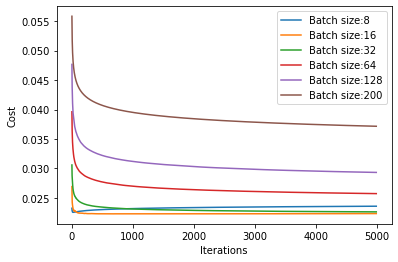

In [304]:
model= LogisticRegression()
batch_sizes=[8, 16, 32, 64, 128, len(X_train1)]
weight_history=[]
for batch_size in batch_sizes:
    #for i, lr in enumerate(learning_rates):
    optimizer = StochasticGradientDescent(learning_rate=5, max_iters=5000, record_history=True) 
    W=model.fitSGD(X_train1, Y_train1, optimizer, batch_size)
    Ypredict=model.predict(X_test1)
    print("Cost for batch size", batch_size, "on test set:", 0.5*np.mean((Y_test1-Ypredict)**2, axis=0))
    costs=[]
    for w in optimizer.w_history:
      costs.append(model.cost_fn(np.c_[np.ones((X_test1).shape[0]), (X_test1)] , np.squeeze(Y_test1), w))
    plt.plot(np.arange(len(costs[3:])), costs[3:], label='Batch size:'+str(batch_size))

plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel("Cost")
plt.xlabel("Iterations")
plt.show()

#Deprecated

## Gradient descent

#Full batch GD

In [305]:
optimizer = GradientDescent(learning_rate=0.1, max_iters=1e4, record_history=False)
model= LinearRegression()
model.fitGD(X_train, Y_train, optimizer)

array([[ -1.6028632 ,  -0.35035649],
       [-15.11163448, -14.52996866],
       [  2.31794188,   2.54945555],
       [ 13.23331016,   9.18169399],
       [ -8.24856616,  -3.99759804],
       [ 33.71834266,  35.61148416],
       [  8.38881523,   6.10534053]])

In [306]:
Ypredict=model.predict(X_test)
#print(np.c_[Y_test, Ypredict])
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[3.86817989 5.50777535]


##Stochastic

In [307]:
optimizer = StochasticGradientDescent(learning_rate=0.5, max_iters=1e4, record_history=False) 
model= LinearRegression()
model.fitSGD(X_train, Y_train, optimizer, 24)

array([[ -3.80155984,  -2.76267208],
       [-16.55559874, -16.1643752 ],
       [ -3.23850556,  -3.3799684 ],
       [-23.73384054, -30.44109515],
       [ 16.47803366,  22.55331446],
       [ 55.95152782,  59.52595038],
       [  8.07616339,   5.77085268]])

In [308]:
Ypredict=model.predict(X_test)
loss=0.5*np.mean((Y_test-Ypredict)**2, axis=0)
print(loss)

[10.47277747 13.78534762]


In [309]:
print(np.c_[Y_test, Ypredict])

[[19.95       21.97       29.49836521 33.66776661]
 [18.31       27.87       29.49836521 33.66776661]
 [28.75       39.44       27.69241838 31.03621295]
 [23.93       29.4        22.08186846 23.55073568]
 [ 6.37       11.27       10.45472501 15.1752382 ]
 [ 6.85       11.74        9.29834957 13.61204746]
 [ 7.18       12.4         8.31090882 12.21379934]
 [10.54       16.8         7.15453338 10.6506086 ]
 [10.77       16.75        7.15453338 10.6506086 ]
 [10.56       16.67        7.15453338 10.6506086 ]
 [ 8.5        12.04        5.99815794  9.08741787]
 [29.87       29.87       27.71280297 30.25655616]
 [26.91       25.6        31.51740606 35.11047978]
 [26.37       27.03       31.51740606 35.11047978]
 [32.94       34.14       24.10090931 24.99344885]
 [10.36       13.43       13.46120661 18.0161995 ]
 [11.11       14.28       11.31739042 15.05476063]
 [11.09       14.3        11.31739042 15.05476063]
 [11.68       13.9        10.32994966 13.65651251]
 [11.7        13.88       10.32

##Confusion matrix

In [310]:
def confusion_matrix(y, yh):
    n_classes = np.max(y) + 1
    c_matrix = np.zeros((n_classes, n_classes))
    for c1 in range(n_classes):
        for c2 in range(n_classes):
            #(y==c1)*(yh==c2) is 1 when both conditions are true or 0
            c_matrix[c1, c2] = np.sum((y==c1)*(yh==c2))
    return c_matrix



## Logistic Regression

In [311]:
df2.head()

,0,1,2,3,4,5,6
0,P,P,A,A,A,P,NB
1,N,N,A,A,A,N,NB
2,A,A,A,A,A,A,NB
3,P,P,P,P,P,P,NB
4,N,N,P,P,P,N,NB


In [312]:
check_nan = df2.isnull().values.any()
print(check_nan)

False


In [313]:
optimizer = StochasticGradientDescent(learning_rate=0.7, max_iters=5000, record_history=False)#GradientDescent(learning_rate=.0003, max_iters=5000, record_history=False)
model= LogisticRegression()
W=model.fitSGD(X_train, Y_train, optimizer, 10)
Ypredict=model.predict(X_test)
print(model.cost_fn(np.c_[np.ones((X_test).shape[0]), (X_test)] , np.squeeze(Y_test), W))

-inf


<ipython-input-275-d694ec3e7fa7>:38: RuntimeWarning: overflow encountered in exp
  J =np.mean(np.squeeze(y) * np.squeeze(np.log1p(np.exp(-z))) + (1-np.squeeze(y)) * np.squeeze(np.log1p(np.exp(z)))) #log1p calculates log(1+x) to remove floating point inaccuracies


In [314]:
cmat = confusion_matrix(Y_test, (Ypredict>0.5).astype(int))
print(cmat)
print(f'accuracy: {np.sum(np.diag(cmat))/np.sum(cmat)}')

TypeError: ignored

##Cross validation

In [ ]:
loss = lambda y, yh: 0.5*np.mean((y-yh)**2)
num_folds = 5
model = LinearRegression()
learning_rates=[0.01, 0.03, 0.05, 0.1, 0.3]
err_test, err_valid = np.zeros(len(learning_rates)), np.zeros((len(learning_rates), num_folds))
for i, K in enumerate(learning_rates):
    #Find the validation errors for num_folds splits for a given K
    for f, (tr, val) in enumerate(cross_validate(X_train.shape[0], num_folds)):
        optimizer = GradientDescent(learning_rate=K, max_iters=1e4, record_history=False)
        #print(X_train.shape, X_train[tr, :].shape, Y_train.shape, Y_train[tr, :].shape)
        params = model.fitGD(X_train[tr, :], Y_train[tr, :], optimizer)
        err_valid[i, f] = loss(Y_train[val], model.predict(X_train[val]))
    #this is the part that we don't do in a usual setup. We don't touch the test set until the very end. 
    params = model.fitGD(X_train[tr], Y_train[tr], optimizer)
    err_test[i]= loss(Y_test, model.predict(X_test))
    
plt.plot(learning_rates, err_test,  label='test')
plt.errorbar(learning_rates, np.mean(err_valid, axis=1), np.std(err_valid, axis=1), label='validation')
plt.legend()
plt.xlabel('Learning Rate)')
plt.ylabel('mean squared error')
plt.show()